In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Data Augmentation-XrayImg

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Data Augmentation-XrayImg


# 0. Setup 

In [ ]:
#data
%cd original/
!curl -L "https://app.roboflow.com/ds/hFAZvtsbYG?key=5beMU2HYuQ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd ..

In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/{cu_version}/{torch_version}/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/{cu_version}/{torch_version}/index.html
     |████████████████████████████████| 256kB 17.6MB/s 
     |████████████████████████████████| 194kB 41.7MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.3.0-cp37-cp37m-linux_x86_64.whl size=22531954 sha256=a2511f09adba13027549fbd1de377c25abd7746c93bd598b6c49dd6aa97d9c83
  Stored in directory: /root/.cache/pip/wheels/34/60/a1/e53785d2fbb520db58f2d77b4fca2b34435d2ef2015c18d608
Successfully built mmcv-full


In [ ]:
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
!pip install -r requirementsa/build.txt
!pip install -v -e .
!mkdir checkpoints/ 

In [ ]:
import torch
from torch.utils.data import Dataset
import os
import glob
import cv2
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import mmcv
from mmdet.apis import init_detector, inference_detector
import numpy as np 

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

# 1. Segmentation

In [ ]:
!wget -P ./checkpoints/ http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth

--2021-04-09 13:53:04--  http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177867103 (170M) [application/octet-stream]
Saving to: ‘./checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’

mask_rcnn_r50_caffe 100%[===================>] 169.63M  7.88MB/s    in 23s     

2021-04-09 13:53:28 (7.36 MB/s) - ‘./checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth’ saved [177867103/177867103]



In [ ]:
# TRAIN Seg
!python3 ./tools/train.py ../train_xray_segm.py

In [ ]:
config_file = '../train_xray_segm.py'
checkpoint_file = './work_dirs/train_xray_segm/latest.pth'

In [ ]:

def convert_bin(result):
  x=result[1][0][0]
  new_result=[]
  for i in range(len(x)):
    new_x=[]
    for j in range(len(x[i])):
      if x[i][j]:
        new_x.append(1)
      else:
        new_x.append(0)
    new_result.append(new_x)
  return new_result # mask
      

def remove_background(img,mask):
  
  img=np.transpose(img, (2, 0, 1))
  for channel in img:
    for i in range(len(channel)):
      for j in range(len(channel[i])):
        if mask[i][j]==0:
          channel[i][j]=0
  
  return np.transpose(img, (1, 2, 0))


def equalize_clahe_color(img):
    cla = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(20, 20))
    channels = cv2.split(img)
    eq_channels = []
    for ch in channels:
        eq_channels.append(cla.apply(ch))
    eq_image = cv2.merge(eq_channels)
    return eq_image


def save_new_img(model,original_img_folder,save_img_folder):
  image_paths = glob.glob(os.path.join(original_img_folder,'*.jpg'))
  for img_path in image_paths:
    img=cv2.imread(img_path)
    result=inference_detector(model.cpu(), img_path)
    new_re=convert_bin(result)
    new_re=np.array(new_re)
    new_re=remove_background(img,new_re)
    clahe_img=equalize_clahe_color(new_re)
    save_img_path=os.path.join(save_img_folder,img_path.split('/')[-1])
    cv2.imwrite(save_img_path,clahe_img)

Use load_from_local loader


/content/gdrive/My Drive/Data Augmentation-XrayImg/mmdetection/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


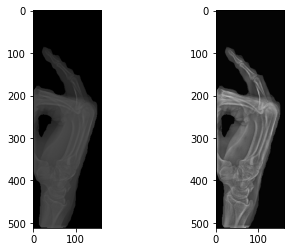

In [ ]:
# Test Seg
seg_model = init_detector(config_file, checkpoint_file, device=device)
img_paths=glob.glob('../original/dataDetect_test/*.png')
path = next(iter(img_paths))
img=cv2.imread(path)
result=inference_detector(seg_model.cpu(), path)
new_re=convert_bin(result)
new_re=np.array(new_re)
new_re=remove_background(img,new_re)
new_re=equalize_clahe_color(new_re)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(new_re)
plt.show()

In [ ]:
# I can't find the preprocessing config so far --> Just for now : 
save_new_img(seg_model,'../original/train/','../original/train/')
save_new_img(seg_model,'../original/valid/','../original/valid/')
save_new_img(seg_model,'../original/test/','../original/test/')

In [ ]:
%cd mmdetection

# 2. Object Detection

In [ ]:
!wget -P ./checkpoints/ http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_2x_coco/faster_rcnn_r50_caffe_fpn_mstrain_2x_coco_bbox_mAP-0.397_20200504_231813-10b2de58.pth

--2021-04-09 15:12:49--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_2x_coco/faster_rcnn_r50_caffe_fpn_mstrain_2x_coco_bbox_mAP-0.397_20200504_231813-10b2de58.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167291065 (160M) [application/octet-stream]
Saving to: ‘./checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_2x_coco_bbox_mAP-0.397_20200504_231813-10b2de58.pth’

faster_rcnn_r50_caf 100%[===================>] 159.54M  7.78MB/s    in 20s     

2021-04-09 15:13:11 (8.07 MB/s) - ‘./checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_2x_coco_bbox_mAP-0.397_20200504_231813-10b2de58.pth’ saved [167291065/167291065]



In [ ]:
!python3 ./tools/train.py ../train_xray.py

In [ ]:
from mmdet.apis import init_detector, inference_detector
!python3 ./tools/test.py ../train_xray.py ./work_dirs/train_xray/latest.pth --eval bbox

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Use load_from_local loader
[>>] 40/40, 9.0 task/s, elapsed: 4s, ETA:     0s
Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.143
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.384
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.116
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.144
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.300
Average Recall     (AR) @[ IoU=0.50:0.95 | area=  

Use load_from_local loader


/content/gdrive/My Drive/Data Augmentation-XrayImg/mmdetection/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


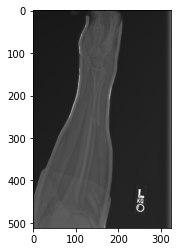

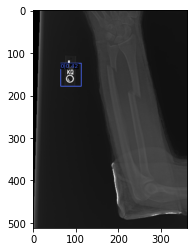

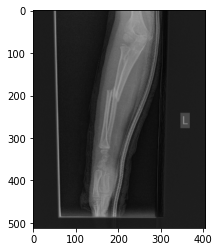

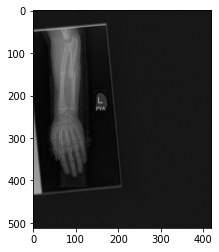

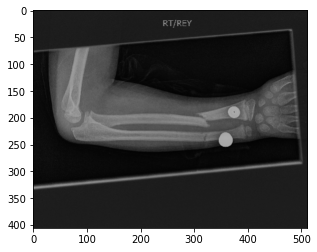

In [ ]:
config_file = '../train_xray.py'
checkpoint_file = './work_dirs/train_xray/latest.pth'
device = 'cuda:0'
# init a detector
model = init_detector(config_file, checkpoint_file, device=device)
# inference the demo image
img_paths=glob.glob('../original/dataDetect_test/*.png')
for path in img_paths[35:40]:
  result=inference_detector(model, path)
  img=cv2.imread(path)
  plt.imshow(model.show_result(img, result))
  plt.show()